# Navier-Stokes

\begin{align}
  \varrho\left(\frac{\partial u}{\partial t} +
  u \cdot \nabla u\right) &= \nabla\cdot\sigma(u, p) + f, \\ 
  \nabla \cdot u &= 0
\end{align}
  
where:
  
$f$ is a given force per unit volume, and

$\sigma(u, p) = 2\mu\epsilon(u) - pI$  is the stress tensor for a Newtonian fluid,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\epsilon(u) = \frac{1}{2}\left(\nabla u + (\nabla u)^T\right)$ is the stress-rate tensor, and 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$μ$ is the dynamic viscosity.

The simulation uses the IPCS splitting method (based on Chorin's method).

In [1]:
from fenics import *
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt

In [2]:
def calculate_simulation_channel_flow(nx, ny, nt, dt=None, tmax=None, mu=1.0, rho=1.0):
    if dt is not None and tmax is not None:
        raise ValueError("For a given number of points, dt and tmax cannot both be defined.")
    elif dt is None and tmax is None:
        raise ValueError("For a given number of points, either dt or tmax should be set.")
    elif dt is None:
        dt = tmax/nt
    elif tmax is None:
        tmax = dt*nt
    
    # Mesh setup
    mesh = UnitSquareMesh(nx, ny)
    mesh_info = {'mesh':mesh, 'nx':nx, 'ny':ny, 'nt':nt, 'dt':dt, 'tmax':tmax}

    # Variables setup
    V = VectorFunctionSpace(mesh, 'P', 2) #velocity function space
    Q = FunctionSpace(mesh, 'P', 1) #pressure function space
    # Trial & test functions
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    # Most recent approximations
    u_  = Function(V)
    p_  = Function(Q)
    # Previous solutions
    u_n = Function(V)
    p_n = Function(Q)

    # Boundary setup
    inflow   = 'near(x[0], 0)'
    outflow  = 'near(x[0], 1)'
    walls    = 'near(x[1], 0) || near(x[1], 1)'
    # Define boundary conditions
    bc_u_noslip  = DirichletBC(V, Constant((0, 0)), walls)
    bc_p_inflow  = DirichletBC(Q, Constant(8), inflow)
    bc_p_outflow = DirichletBC(Q, Constant(0), outflow)
    bc_u = [bc_u_noslip]
    bc_p = [bc_p_inflow, bc_p_outflow]

    
    # Variational problem
    
    # Constants
    U   = 0.5*(u_n + u)
    n   = FacetNormal(mesh)
    f   = Constant((0, 0))
    k   = Constant(dt)
    mu  = Constant(mu) #kinematic velocity
    rho = Constant(rho) #density
    # Intermediate functions
    def epsilon(u): #strain-rate tensor
        return sym(nabla_grad(u))
    def sigma(u, p): #stress tensor
        return 2*mu*epsilon(u) - p*Identity(len(u))

    # Define variational problem for step 1
    F1 = ( rho*dot((u - u_n) / k, v)*dx
         + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx 
         + inner(sigma(U, p_n), epsilon(v))*dx 
         + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds 
         - dot(f, v)*dx )
    a1 = lhs(F1)
    L1 = rhs(F1)
    
    # Step 2
    a2 = dot(nabla_grad(p), nabla_grad(q))*dx
    L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

    # Step 3
    a3 = dot(u, v)*dx
    L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
    
    # Assemble matrices
    A1 = assemble(a1)
    A2 = assemble(a2)
    A3 = assemble(a3)

    # Apply boundary conditions to matrices
    [bc.apply(A1) for bc in bc_u]
    [bc.apply(A2) for bc in bc_p]
    
    # Logs
    logs = {'t':[], 'u':[], 'p':[], 'error_u_L2':[], 'error_u_max':[], 'error_p_L2':[], 'error_p_max':[]}
    
    #Log initial values
    logs['t'].append(0)
    logs['u'].append(interpolate(Expression(('0', '0'), degree=2), V))
    logs['p'].append(interpolate(Expression('0', degree=2), Q))
    logs['error_u_L2'].append(0)
    logs['error_u_max'].append(0)
    logs['error_p_L2'].append(0)
    logs['error_p_max'].append(0)
    
    # Solving
    t=0
    for i in range(nt):
        t += dt
        
        # Step 1: Tentative velocity step
        b1 = assemble(L1)
        [bc.apply(b1) for bc in bc_u]
        solve(A1, u_.vector(), b1)

        # Step 2: Pressure correction step
        b2 = assemble(L2)
        [bc.apply(b2) for bc in bc_p]
        solve(A2, p_.vector(), b2)

        # Step 3: Velocity correction step
        b3 = assemble(L3)
        solve(A3, u_.vector(), b3)
        
        # Assignment for previous solutions
        u_n.assign(u_)
        p_n.assign(p_)

        # Compute errors for u
        u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
        vertex_values_u_e = u_e.compute_vertex_values(mesh)
        vertex_values_u = u_n.compute_vertex_values(mesh)
        error_u_L2 = errornorm(u_e, u_n, norm_type='L2')
        error_u_max = np.max(np.abs(vertex_values_u_e - vertex_values_u))
        #print('t = %.2f: error = %.3g' % (t, error))
        #print('max u:', u_.vector().array().max())
        # Compute errors for p
        p_e = Expression('0', degree=2)
        vertex_values_p_e = p_e.compute_vertex_values(mesh)
        vertex_values_p = p_n.compute_vertex_values(mesh)
        error_p_L2 = errornorm(p_e, p_n, norm_type='L2')
        error_p_max = np.max(np.abs(vertex_values_p_e - vertex_values_p))
        #print('t = %.2f: error = %.3g' % (t, error))
        #print('max u:', u_.vector().array().max())

        # Log current values
        logs['t'].append(t)
        logs['u'].append(u_n.copy(deepcopy=True))
        logs['error_u_L2'].append(error_u_L2)
        logs['error_u_max'].append(error_u_max)
        logs['p'].append(p_n.copy(deepcopy=True))
        logs['error_p_L2'].append(error_p_L2)
        logs['error_p_max'].append(error_p_max)
        
        
    return mesh_info, logs

mesh_info, logs = calculate_simulation_channel_flow(18, 19, 20, tmax=1.0)

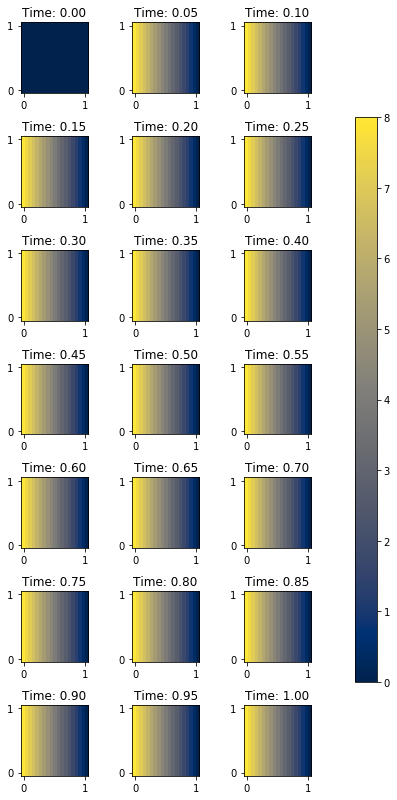

In [3]:
def display_simulation(mesh_info, logs, nplots_max=None, nrows_max=None, show_bounds=False, scalemin=1, scalemax=8):

    # Retrieve variables
    mesh = mesh_info['mesh']
    coords = mesh.coordinates()
    nx = mesh_info['nx']
    ny = mesh_info['ny']
    nt = mesh_info['nt']
    u_hist = logs['u']
    p_hist = logs['p']
    t_hist = logs['t']

    # Default values
    if nplots_max is None: 
        nplots_max = 1e19
    if nrows_max is None:
        nrows_max = 1e19
    nplots = min(nt+1, nplots_max)
    skipper = int(np.ceil((nt+1)/nplots))

    ncols = int(np.ceil(nplots/nrows_max))
    nrows = int(np.ceil(nplots/ncols))
    figsize = np.array([ncols, 0.8*nrows])*2     # figure size, inches
    scalemin, scalemax = scalemin, scalemax #Decided arbitrarily to scale the plots to a standard scale.
                               #Ideally, we would scale everything based on the min and max over all time,
                               #but here we are plotting before doing the entire calculation.

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)


    for i in range(nplots):
        axi = axes.flat[i]
        # i runs from 0 to (nrows*ncols-1)
        # axi is equivalent with ax[rowid][colid]
        vertex_values_p = p_hist[i].compute_vertex_values(mesh).reshape(ny+1, nx+1)
        img = axi.imshow(vertex_values_p, origin='lower', extent=(-0.05, 1.05, -0.05, 1.05), aspect=ny/nx, 
                         cmap='cividis', vmin=scalemin, vmax=scalemax)
        axi.set_title(f'Time: {t_hist[i]:.2f}')
        
        if show_bounds:
            maj_locator = plt.FixedLocator([0, 1])
        if not show_bounds:
            maj_locator = plt.NullLocator()
        axi.xaxis.set_major_locator(maj_locator)
        axi.yaxis.set_major_locator(maj_locator)
        axi.xaxis.set_minor_locator(plt.NullLocator())
        axi.yaxis.set_minor_locator(plt.NullLocator())

    plt.tight_layout(True)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(img, cax=cbar_ax)

    plt.show()
    
display_simulation(mesh_info, logs, nrows_max=7, show_bounds=True, scalemin=0, scalemax=8)

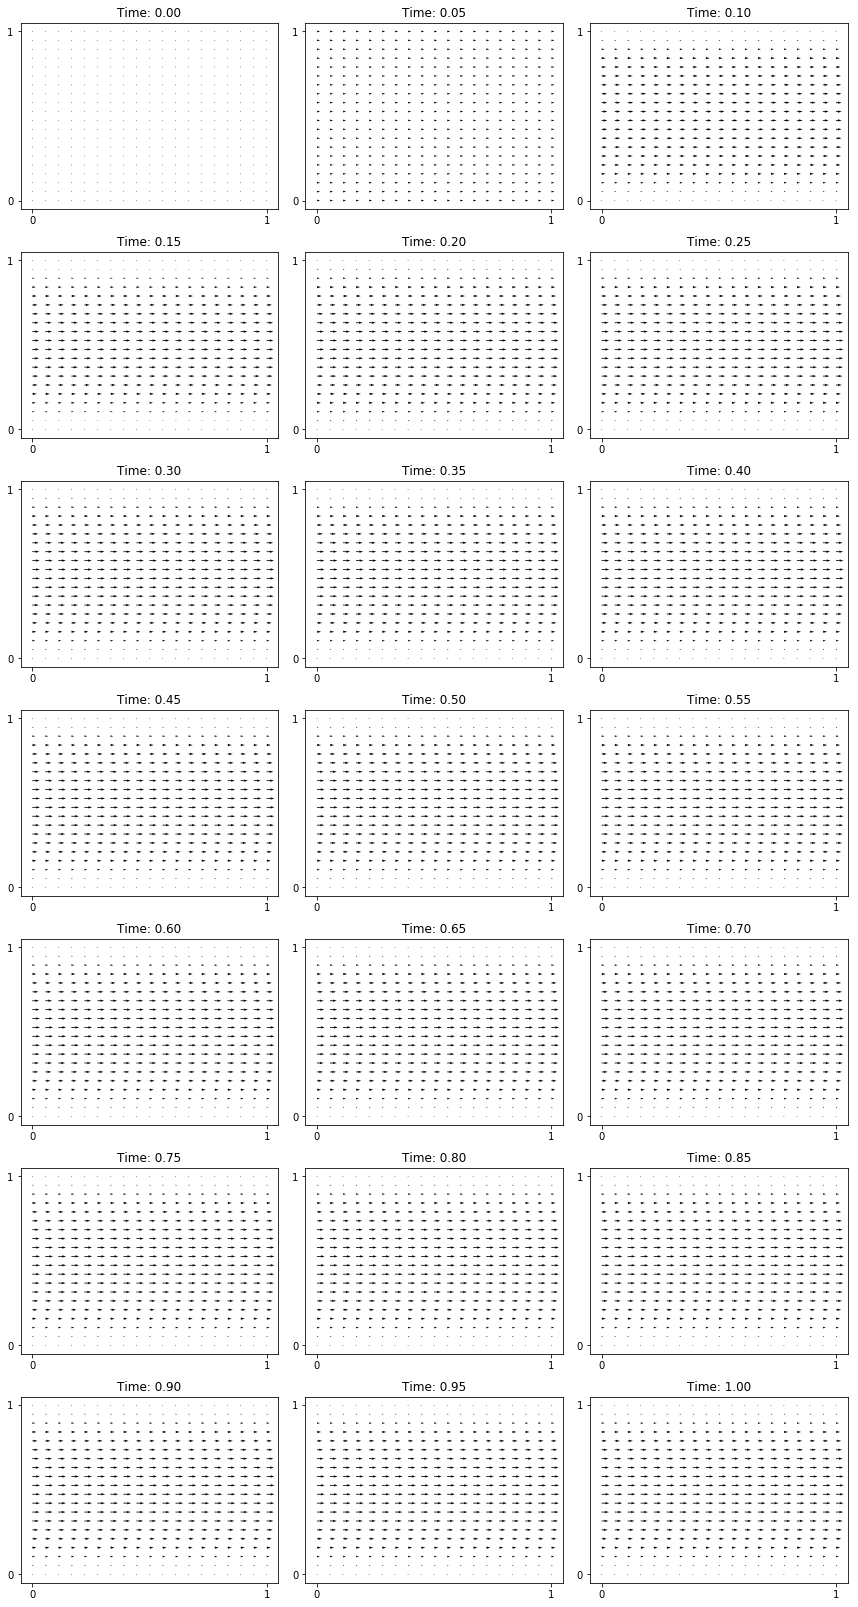

In [6]:
def display_simulation(mesh_info, logs, nplots_max=None, nrows_max=None, show_bounds=False, scalemin=1, scalemax=8):

    # Retrieve variables
    mesh = mesh_info['mesh']
    nx = mesh_info['nx']
    ny = mesh_info['ny']
    nt = mesh_info['nt']
    #coords = mesh.coordinates().reshape(ny+1, nx+1, 2)
    #coords_x = coords[0, :, 0]
    #coords_y = coords[:, 0, 1]
    coords = mesh.coordinates()
    coords_x = coords[:, 0]
    coords_y = coords[:, 1]
    u_hist = logs['u']
    p_hist = logs['p']
    t_hist = logs['t']

    # Default values
    if nplots_max is None: 
        nplots_max = 1e19
    if nrows_max is None:
        nrows_max = 1e19
    nplots = min(nt+1, nplots_max)
    skipper = int(np.ceil((nt+1)/nplots))

    ncols = int(np.ceil(nplots/nrows_max))
    nrows = int(np.ceil(nplots/ncols))
    figsize = np.array([ncols, 0.8*nrows])*4     # figure size, inches
    scalemin, scalemax = scalemin, scalemax #Decided arbitrarily to scale the plots to a standard scale.
                               #Ideally, we would scale everything based on the min and max over all time,
                               #but here we are plotting before doing the entire calculation.

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)


    for i in range(nplots):
        axi = axes.flat[i]
        # i runs from 0 to (nrows*ncols-1)
        # axi is equivalent with ax[rowid][colid]
        #vertex_values_u = u_hist[i].compute_vertex_values(mesh).reshape(2, (ny+1),(nx+1)).T
        vertex_values_u = u_hist[i].compute_vertex_values(mesh).reshape(2, -1)
        #img = axi.quiver(coords_x, coords_y, vertex_values_u[:,:,0], vertex_values_u[:,:,1])
        img = axi.quiver(coords_x, coords_y, vertex_values_u[0], vertex_values_u[1], scale_units='xy', scale=30)
        axi.set_title(f'Time: {t_hist[i]:.2f}')
        
        if show_bounds:
            maj_locator = plt.FixedLocator([0, 1])
        if not show_bounds:
            maj_locator = plt.NullLocator()
        axi.xaxis.set_major_locator(maj_locator)
        axi.yaxis.set_major_locator(maj_locator)
        axi.xaxis.set_minor_locator(plt.NullLocator())
        axi.yaxis.set_minor_locator(plt.NullLocator())

    plt.tight_layout(True)

    plt.show()
    
display_simulation(mesh_info, logs, nrows_max=7, show_bounds=True, scalemin=0, scalemax=8)

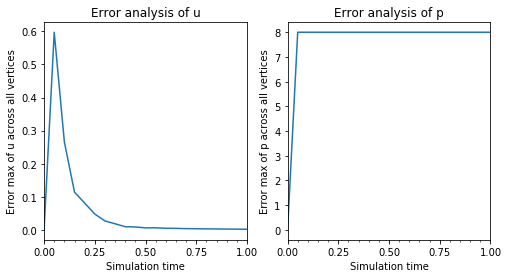

([<matplotlib.axes._subplots.AxesSubplot at 0x7fe6ecb190b8>,
  <matplotlib.lines.Line2D at 0x7fe6ecb14e80>])

In [18]:
def display_error(error_type, mesh_info, logs, prev_axes=None, major_ticks_period=1, show=True):
    #the simulation time is displayed every 'major_ticks_period' times the timestep dt
    #'show' is false when the function is used as an intermediate step (if the axis will be used for further plotting)
    
    if prev_axes is None:
        fig = plt.figure(figsize=(8, 4))
        axes = [fig.add_subplot(121), fig.add_subplot(122)]
    else:
        axes = prev_axes
    
    artists = []
    color = next(axes[0]._get_lines.prop_cycler)['color']
    
    artist, = axes[0].plot(logs['t'], logs['error_u_'+error_type], color=color)
    artists.append(artist)
    axes[0].margins(x=0)
    axes[0].set_title('Error analysis of u')
    axes[0].set_xlabel('Simulation time')
    axes[0].set_ylabel('Error '+str(error_type)+' of u across all vertices')
    
    artist, = axes[1].plot(logs['t'], logs['error_p_'+error_type], color=color)
    artists.append(artist)
    axes[1].margins(x=0)
    axes[1].set_title('Error analysis of p')
    axes[1].set_xlabel('Simulation time')
    axes[1].set_ylabel('Error '+str(error_type)+' of p across all vertices')
    
    if show:
        axes[0].xaxis.set_major_locator(plt.MultipleLocator(mesh_info['dt']*major_ticks_period))
        axes[0].xaxis.set_minor_locator(plt.MultipleLocator(mesh_info['dt']))
        axes[1].xaxis.set_major_locator(plt.MultipleLocator(mesh_info['dt']*major_ticks_period))
        axes[1].xaxis.set_minor_locator(plt.MultipleLocator(mesh_info['dt']))
        plt.show()
    return axes, artists
    
display_error('max', mesh_info, logs, major_ticks_period=5)

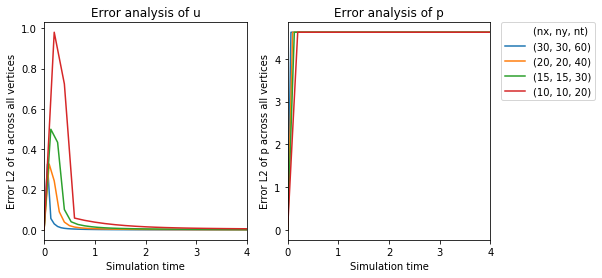

In [19]:
from matplotlib.patches import Patch

def display_errors(error_type, nxs, nys, nts, tmax):
    nxs, nys, nts = np.sort(nxs)[::-1], np.sort(nys)[::-1], np.sort(nts)[::-1]
    
    # Display setup
    prev_axes = None
    artistss = []
    
    # Reuse smallest value of n_s if their are smaller values of a different n_s to get through
    len_max = max(len(nxs), len(nys), len(nts))
    for n_s in [nxs, nys, nts]:
        if len(n_s) < len_max:
            n_missing = len_max - len(n_s)
            n_s = n_s + [n_s]*n_missing
    
    # Iteration
    for i in range(len_max):
            
        # calculation step
        mesh_info, logs = calculate_simulation_channel_flow(nxs[i], nys[i], nts[i], tmax=tmax)
        
        # display step
        prev_axes, prev_artists = display_error(error_type, mesh_info, logs, prev_axes=prev_axes, show=False)
        artistss.append(prev_artists)
        
    # Final touches
    empty_artist = Patch(color='white', label=str((nxs, nys, nts)))
    prev_axes[1].legend([empty_artist]+[artists[1] for artists in artistss], ['(nx, ny, nt)']+list(zip(nxs, nys, nts)), 
                   bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
            
display_errors('L2', [10, 15, 20, 30], [10, 15, 20, 30], [20, 30, 40, 60], 4.0)

In [ ]:
def calculate_convergence(initial_n, increase_factor_n, iterations, tmax):
    #increase_factor_n is decides how many more points are in the nest mesh
    if type(increase_factor_n) is not int:
        raise ValueError("increase_factor_n should be an integer")
    if initial_n <= 0 or type(initial_n) is not int:
        raise ValuError("initial_n should be a positive integer")
    
    # Logs
    hs = []
    errors_L2 = []
    
    for i in range(iterations):
        if i == 0:
            n = initial_n
        else:
            n *= increase_factor_n
        mesh_info, logs = calculate_simulation_channel_flow(n, n, n, tmax=tmax)
        print(n)
        hs.append(1/n)
        errors_L2.append(logs['error_u_L2'][-1])
        
    hs = np.array(hs)
    errors_L2 = np.array(errors_L2)
    convergence_rates = np.log(errors_L2[1:]/errors_L2[:-1])/np.log(hs[1:]/hs[:-1])
    return hs[1:], convergence_rates

hs, convergence_rates = calculate_convergence(initial_n=4, increase_factor_n=2, iterations=7, tmax=4.0)

4
8
16
32
64
128


In [ ]:
def display_convergence(hs, convergence_rates):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(hs, convergence_rates)
    
    ax.set_title("Convergence")
    ax.set_xlabel("h")
    ax.set_ylabel("convergence rate")
    
    plt.show()
    
display_convergence(hs, convergence_rates)

In [ ]:
### other

In [ ]:
uvals = u_hist[0].compute_vertex_values()
xyvals = mesh.coordinates()
xvals = xyvals[:,0]
yvals=xyvals[:,1]

xx = np.linspace(0,1)
yy = np.linspace(0,1)

XX, YY = np.meshgrid(xx,yy)

from scipy.interpolate import griddata
uu = griddata(xyvals, uvals, (XX, YY), method='linear')
plt.imshow(uu, origin='lower', extent=(-5e-3, 1+5e-3, -5e-3, 1+5e-3))